In [1]:
import numpy as np
import pandas as pd
import time

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot(dataset, solution, title):
    max_x = dataset['x'].max()
    max_y = dataset['y'].max()

    aspect_ratio = int(max_x / max_y)

    if max_x > max_y:
        height = 6.0
        width = height * aspect_ratio
    else:
        width = 6.0
        height = width * aspect_ratio

    sns.set_theme(rc={'figure.figsize': (width, height)})

    sns.scatterplot(
        data=dataset,
        x='x',
        y='y',
        size='cost',
        legend=False
    )

    for i in range(-1, len(solution) - 1):
        idx1 = solution[i]
        idx2 = solution[i + 1]
        x_values = [dataset.loc[idx1, "x"], dataset.loc[idx2, "x"]]
        y_values = [dataset.loc[idx1, "y"], dataset.loc[idx2, "y"]]
        plt.plot(
            x_values,
            y_values,
            color="b",
            linestyle="-",
        )



    plt.title(title)
    plt.show();

In [3]:
np.random.seed(1337)

dataset_A = pd.read_csv('./TSPA.csv', sep=';', names=['x', 'y', 'cost'])
dataset_B = pd.read_csv('./TSPB.csv', sep=';', names=['x', 'y', 'cost'])

dataset_A.shape, dataset_B.shape

((200, 3), (200, 3))

In [4]:
def euclidean_distance(node1, node2):
    return np.int32(((node1['x'] - node2['x']) ** 2 + (node1['y'] - node2['y']) ** 2) ** 0.5 + 0.5)

In [5]:
def nodes_cost(node1, node2):
    return node1['cost'] + node2['cost']

In [6]:
def calculate_function_cost(dataset):
    cost = 0

    x = dataset['x'].to_numpy()
    y = dataset['y'].to_numpy()

    for i in range(len(x) - 1):
        cost += euclidean_distance({'x': x[i], 'y': y[i]}, {'x': x[i+1], 'y': y[i+1]})

    cost += euclidean_distance({'x': x[-1], 'y': y[-1]}, {'x': x[0], 'y': y[0]})

    cost += dataset['cost'].sum()

    return int(cost)

In [7]:
def calculate_distance_matrix(dataset):
    num_nodes = len(dataset)

    distance_matrix = np.zeros((num_nodes, num_nodes), dtype=np.float64)

    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                node1 = dataset.iloc[i]
                node2 = dataset.iloc[j]
                distance = euclidean_distance(node1, node2)

                if np.isinf(distance) or np.isnan(distance):
                    raise ValueError(f"Invalid distance encountered between nodes {i} and {j}")

                cost = nodes_cost(node1, node2) * 0.5
                distance_matrix[i, j] = distance + cost

    return distance_matrix

In [8]:
distance_matrix_A = calculate_distance_matrix(dataset_A)
distance_matrix_A


array([[   0. , 2286. , 2464. , ..., 1963.5, 1482.5, 2001.5],
       [2286. ,    0. ,  706. , ..., 2687.5, 2731.5, 3460.5],
       [2464. ,  706. ,    0. , ..., 2948.5, 2966.5, 3699.5],
       ...,
       [1963.5, 2687.5, 2948.5, ...,    0. , 1850. , 2459. ],
       [1482.5, 2731.5, 2966.5, ..., 1850. ,    0. , 1989. ],
       [2001.5, 3460.5, 3699.5, ..., 2459. , 1989. ,    0. ]])

In [9]:
distance_matrix_B = calculate_distance_matrix(dataset_B)
distance_matrix_B

array([[   0. , 2133.5, 1331. , ..., 2453.5, 2131. , 1669.5],
       [2133.5,    0. , 1901.5, ...,  568. ,  638.5, 3720. ],
       [1331. , 1901.5,    0. , ..., 2221.5, 1996. , 2786.5],
       ...,
       [2453.5,  568. , 2221.5, ...,    0. ,  945.5, 4041. ],
       [2131. ,  638.5, 1996. , ...,  945.5,    0. , 3745.5],
       [1669.5, 3720. , 2786.5, ..., 4041. , 3745.5,    0. ]])

In [10]:
import time
from typing import Tuple, List

class SelectiveTSP_SA:
    def __init__(self, distance_matrix: np.ndarray,
                 selection_percentage: float = 0.5,
                 initial_temp: float = 10_000, cooling_rate: float = 0.99,
                 iterations_per_temp: int = 1000, min_temp: float = 1,
                 max_time: float = 120):  # 2 minutes max runtime
        self.distances = distance_matrix
        self.n_cities = len(distance_matrix)
        self.n_selected = int(np.ceil(self.n_cities * selection_percentage))
        self.initial_temp = initial_temp
        self.cooling_rate = cooling_rate
        self.iterations_per_temp = iterations_per_temp
        self.min_temp = min_temp
        self.max_time = max_time

    def calculate_tour_length(self, tour: np.ndarray) -> float:
        """Calculate the total length of a tour using numpy."""
        return np.sum(self.distances[tour, np.roll(tour, -1)])

    def generate_initial_solution(self) -> np.ndarray:
        """Generate random initial solution using numpy."""
        return np.random.choice(self.n_cities, size=self.n_selected, replace=False)

    def generate_neighbor(self, current_solution: np.ndarray) -> Tuple[np.ndarray, str]:
        """Generate a neighbor solution using numpy operations."""
        operation = np.random.choice(['swap', 'reverse', 'replace'])
        new_solution = current_solution.copy()

        if operation == 'swap':
            idx1, idx2 = np.random.choice(len(new_solution), size=2, replace=False)
            new_solution[idx1], new_solution[idx2] = new_solution[idx2], new_solution[idx1]

        elif operation == 'reverse':
            idx1, idx2 = sorted(np.random.choice(len(new_solution), size=2, replace=False))
            new_solution[idx1:idx2+1] = new_solution[idx1:idx2+1][::-1]

        else:  # replace
            unselected_mask = np.ones(self.n_cities, dtype=bool)
            unselected_mask[current_solution] = False
            unselected = np.where(unselected_mask)[0]
            if len(unselected) > 0:
                idx = np.random.randint(len(new_solution))
                new_city = np.random.choice(unselected)
                new_solution[idx] = new_city

        return new_solution, operation

    def solve(self) -> Tuple[np.ndarray, float, float]:
        """Main simulated annealing algorithm with time tracking."""
        start_time = time.time()

        # Initialize
        current_solution = self.generate_initial_solution()
        current_cost = self.calculate_tour_length(current_solution)
        best_solution = current_solution.copy()
        best_cost = current_cost

        temperature = self.initial_temp
        iteration = 0

        # Main loop
        while temperature > self.min_temp:
            if time.time() - start_time > self.max_time:
                print("Time limit reached!")
                break

            for _ in range(self.iterations_per_temp):
                iteration += 1

                # Generate and evaluate neighbor
                new_solution, _ = self.generate_neighbor(current_solution)
                new_cost = self.calculate_tour_length(new_solution)

                # Accept or reject the neighbor
                if new_cost < current_cost or np.random.random() < np.exp((current_cost - new_cost) / temperature):
                    current_solution = new_solution
                    current_cost = new_cost

                    # Update best solution if necessary
                    if current_cost < best_cost:
                        best_solution = current_solution.copy()
                        best_cost = current_cost

            # Cool down
            temperature *= self.cooling_rate

        runtime = time.time() - start_time
        return best_solution, best_cost, runtime

In [12]:
solver_A = SelectiveTSP_SA(distance_matrix_A)

n_runs = 50

best_lengths = []
run_times = []
overall_best_tour = None
overall_best_length = float('inf')

for i in range(n_runs):
    print(f'Run {i+1}/{n_runs}')
    tour, length, run_time = solver_A.solve()

    best_lengths.append(length)
    run_times.append(run_time)

    if length < overall_best_length:
        overall_best_length = length
        overall_best_tour = tour.copy()

stats = {
    'best_tour': overall_best_tour,
    'best_length': overall_best_length,
    'min_length': min(best_lengths),
    'max_length': max(best_lengths),
    'mean_length': np.mean(best_lengths),
    'min_time': min(run_times),
    'max_time': max(run_times),
    'mean_time': np.mean(run_times),
    'std_length': np.std(best_lengths),
    'std_time': np.std(run_times)
}

stats

Run 1/50
Run 2/50
Run 3/50
Run 4/50
Run 5/50
Run 6/50
Run 7/50
Run 8/50
Run 9/50
Run 10/50
Run 11/50
Run 12/50
Run 13/50
Run 14/50
Run 15/50
Run 16/50
Run 17/50
Run 18/50
Run 19/50
Run 20/50
Run 21/50
Run 22/50
Run 23/50
Run 24/50
Run 25/50
Run 26/50
Run 27/50
Run 28/50
Run 29/50
Run 30/50
Run 31/50
Run 32/50
Run 33/50
Run 34/50
Run 35/50
Run 36/50
Run 37/50
Run 38/50
Run 39/50
Run 40/50
Run 41/50
Run 42/50
Run 43/50
Run 44/50
Run 45/50
Run 46/50
Run 47/50
Run 48/50
Run 49/50
Run 50/50


{'best_tour': array([178, 106,  52,  55, 185,  40, 165,  90,  81, 196,  31,  56, 113,
        175, 171,  16,  78, 145,  92,  57, 129,  25,  44, 120,   2,  75,
        101,  86, 100,  26,  97,   1, 152, 124,  94, 121,  53, 180, 154,
        135,  70, 127, 123, 162, 151, 133,  79,  63,  80, 176,  51, 118,
         59,  65, 116,  43,   5,  42, 184,  84, 112,   4,  10, 177,  30,
         54,  48, 160,  34, 146,  22,  18, 108,  69, 159, 193,  41, 139,
        115,  46,  68, 140,  93, 117,   0, 143, 183,  89,  23, 137, 186,
         15, 148,   9,  62, 102,  49, 144,  14,   3]),
 'best_length': 70176.0,
 'min_length': 70176.0,
 'max_length': 72463.0,
 'mean_length': 71299.44,
 'min_time': 73.5836615562439,
 'max_time': 79.13540029525757,
 'mean_time': 74.82203662872314,
 'std_length': 570.4385737307742,
 'std_time': 0.8582828885102666}

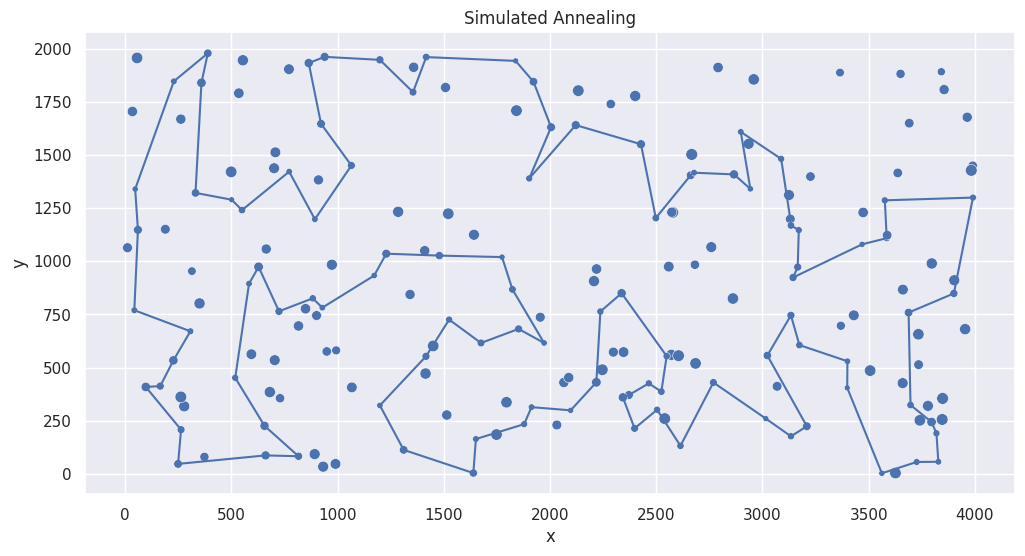

In [13]:
plot(dataset_A, overall_best_tour, "Simulated Annealing")

In [14]:
solver_B = SelectiveTSP_SA(distance_matrix_B)

n_runs = 50

best_lengths = []
run_times = []
overall_best_tour = None
overall_best_length = float('inf')

for i in range(n_runs):
    print(f'Run {i+1}/{n_runs}')
    tour, length, run_time = solver_B.solve()

    best_lengths.append(length)
    run_times.append(run_time)

    if length < overall_best_length:
        overall_best_length = length
        overall_best_tour = tour.copy()

stats = {
    'best_tour': overall_best_tour,
    'best_length': overall_best_length,
    'min_length': min(best_lengths),
    'max_length': max(best_lengths),
    'mean_length': np.mean(best_lengths),
    'min_time': min(run_times),
    'max_time': max(run_times),
    'mean_time': np.mean(run_times),
    'std_length': np.std(best_lengths),
    'std_time': np.std(run_times)
}

stats

Run 1/50
Run 2/50
Run 3/50
Run 4/50
Run 5/50
Run 6/50
Run 7/50
Run 8/50
Run 9/50
Run 10/50
Run 11/50
Run 12/50
Run 13/50
Run 14/50
Run 15/50
Run 16/50
Run 17/50
Run 18/50
Run 19/50
Run 20/50
Run 21/50
Run 22/50
Run 23/50
Run 24/50
Run 25/50
Run 26/50
Run 27/50
Run 28/50
Run 29/50
Run 30/50
Run 31/50
Run 32/50
Run 33/50
Run 34/50
Run 35/50
Run 36/50
Run 37/50
Run 38/50
Run 39/50
Run 40/50
Run 41/50
Run 42/50
Run 43/50
Run 44/50
Run 45/50
Run 46/50
Run 47/50
Run 48/50
Run 49/50
Run 50/50


{'best_tour': array([  0, 109,  35, 106, 124, 128,  62,  18,  55,  34, 170, 152, 183,
        140, 149,  28,  20,  60, 148,  47,  94,  66, 179,  22,  99, 130,
         95, 185,  86, 166, 194, 176, 180, 113, 114, 137, 127,  89, 103,
        163, 187, 153,  81,  77, 141,  91,  61,  36, 177,   5,  78, 175,
        142,  45,  80, 190, 136,  73,  54,  31, 193, 117, 198, 156,   1,
        131, 121,  51, 191,  90, 122, 135,  63,  40, 107, 133,  10, 147,
          6, 188, 169, 132,  70,   3,  15, 145,  13, 195, 168, 139,  11,
        138,  33, 160, 104,   8,  21,  82, 111,  29]),
 'best_length': 43998.0,
 'min_length': 43998.0,
 'max_length': 47077.0,
 'mean_length': 45529.82,
 'min_time': 73.87104153633118,
 'max_time': 84.18788599967957,
 'mean_time': 75.89744759559632,
 'std_length': 677.2261864399516,
 'std_time': 2.345313289962757}

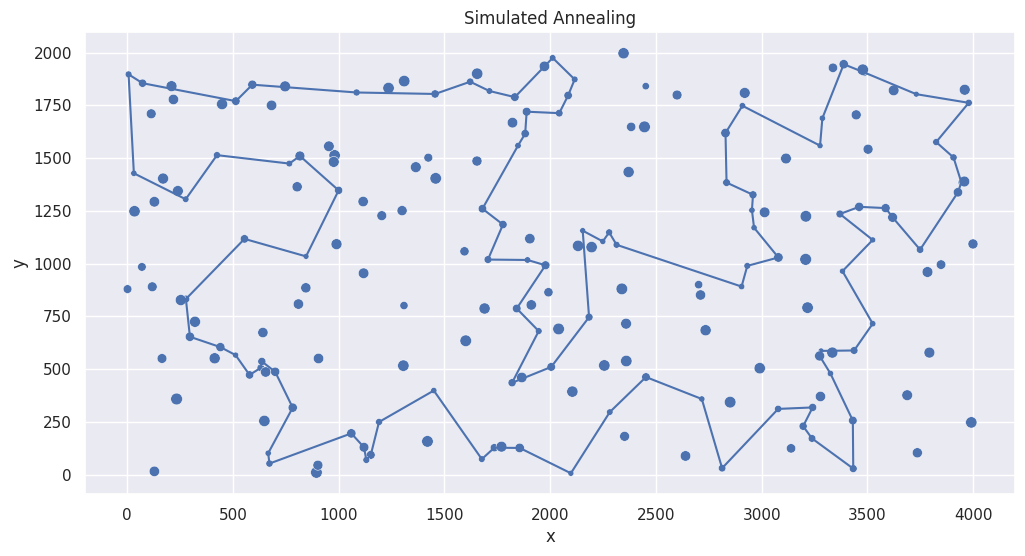

In [15]:
plot(dataset_B, overall_best_tour, "Simulated Annealing")

In [16]:
class SelectiveACO_ILS:
    def __init__(self,
                 distances: np.ndarray,
                 selection_percentage: float = 0.5,
                 n_ants: int = 20,
                 alpha: float = 1.0,
                 beta: float = 2.0,
                 rho: float = 0.1,
                 q0: float = 0.9,
                 max_time: float = 120,
                 ils_iterations: int = 100):

        self.distances = distances
        self.n_cities = len(distances)
        self.n_selected = int(np.ceil(self.n_cities * selection_percentage))
        self.n_ants = n_ants
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.q0 = q0
        self.max_time = max_time
        self.ils_iterations = ils_iterations

        # Initialize pheromone trails
        self.pheromone = np.ones((self.n_cities, self.n_cities))
        self.eta = 1 / (self.distances + np.eye(self.n_cities))

    def construct_solution(self) -> List[int]:
        """Construct solution selecting n_selected cities"""
        ant_tour = []
        available = set(range(self.n_cities))
        current = np.random.randint(self.n_cities)
        ant_tour.append(current)
        available.remove(current)

        while len(ant_tour) < self.n_selected:
            if np.random.random() < self.q0:
                next_city = max(available,
                    key=lambda x: self.pheromone[current][x]**self.alpha *
                                self.eta[current][x]**self.beta)
            else:
                probabilities = []
                for city in available:
                    p = (self.pheromone[current][city]**self.alpha *
                         self.eta[current][city]**self.beta)
                    probabilities.append(p)
                probabilities = np.array(probabilities) / sum(probabilities)
                next_city = np.random.choice(list(available), p=probabilities)

            ant_tour.append(next_city)
            available.remove(next_city)
            current = next_city

        return ant_tour

    def calculate_length(self, tour: List[int]) -> float:
        return sum(self.distances[tour[i]][tour[(i + 1) % len(tour)]]
                  for i in range(len(tour)))

    def generate_neighbor(self, current_solution: List[int]) -> List[int]:
        operation = np.random.choice(['swap', 'reverse', 'replace'])
        new_solution = current_solution.copy()

        if operation == 'swap':
            idx1, idx2 = np.random.choice(len(new_solution), size=2, replace=False)
            new_solution[idx1], new_solution[idx2] = new_solution[idx2], new_solution[idx1]

        elif operation == 'reverse':
            idx1, idx2 = sorted(np.random.choice(len(new_solution), size=2, replace=False))
            new_solution[idx1:idx2+1] = new_solution[idx1:idx2+1][::-1]

        else:  # replace
            unselected = list(set(range(self.n_cities)) - set(current_solution))
            if unselected:
                idx = np.random.randint(len(new_solution))
                new_city = np.random.choice(unselected)
                new_solution[idx] = new_city

        return new_solution

    def local_search(self, tour: List[int], max_iterations: int = 100) -> List[int]:
        current_tour = tour.copy()
        current_length = self.calculate_length(current_tour)

        for _ in range(max_iterations):
            new_tour = self.generate_neighbor(current_tour)
            new_length = self.calculate_length(new_tour)

            if new_length < current_length:
                current_tour = new_tour
                current_length = new_length

        return current_tour

    def solve(self) -> Tuple[List[int], float, float]:
        start_time = time.time()
        best_tour = None
        best_length = float('inf')

        while time.time() - start_time < self.max_time:
            # ACO Phase
            ant_tours = []
            ant_lengths = []

            for _ in range(self.n_ants):
                tour = self.construct_solution()
                # Apply local search to each ant's solution
                improved_tour = self.local_search(tour)
                ant_tours.append(improved_tour)
                ant_lengths.append(self.calculate_length(improved_tour))

            # Update pheromones
            self.pheromone *= (1 - self.rho)

            # Add new pheromones
            for tour, length in zip(ant_tours, ant_lengths):
                delta = 1.0 / length
                for i in range(len(tour)):
                    j = (i + 1) % len(tour)
                    self.pheromone[tour[i]][tour[j]] += delta
                    self.pheromone[tour[j]][tour[i]] += delta

            # Update best solution
            iteration_best_length = min(ant_lengths)
            if iteration_best_length < best_length:
                best_tour = ant_tours[ant_lengths.index(iteration_best_length)].copy()
                best_length = iteration_best_length

        runtime = time.time() - start_time
        return best_tour, best_length, runtime

In [39]:
solver_A = SelectiveACO_ILS(
    distances=distance_matrix_A,
    selection_percentage=0.5,
    n_ants=45,
    alpha=1.3,
    beta=2.8,
    rho=0.12,
    q0=0.82,
    max_time=450,
    ils_iterations=200
)

n_runs = 5

best_lengths = []
run_times = []
overall_best_tour = None
overall_best_length = float('inf')

for i in range(n_runs):
    print(f'Run {i+1}/{n_runs}')
    tour, length, run_time = solver_A.solve()

    best_lengths.append(length)
    run_times.append(run_time)

    if length < overall_best_length:
        overall_best_length = length
        overall_best_tour = tour.copy()

stats = {
    'best_tour': overall_best_tour,
    'best_length': overall_best_length,
    'min_length': min(best_lengths),
    'max_length': max(best_lengths),
    'mean_length': np.mean(best_lengths),
    'min_time': min(run_times),
    'max_time': max(run_times),
    'mean_time': np.mean(run_times),
    'std_length': np.std(best_lengths),
    'std_time': np.std(run_times)
}

stats

Run 1/5
Run 2/5
Run 3/5
Run 4/5
Run 5/5


{'best_tour': [12,
  124,
  94,
  152,
  97,
  1,
  101,
  75,
  86,
  26,
  100,
  121,
  53,
  180,
  154,
  135,
  70,
  123,
  162,
  151,
  133,
  79,
  63,
  80,
  176,
  51,
  118,
  59,
  65,
  116,
  42,
  43,
  184,
  35,
  84,
  112,
  4,
  190,
  10,
  177,
  54,
  30,
  48,
  160,
  34,
  22,
  193,
  41,
  139,
  115,
  46,
  68,
  0,
  143,
  183,
  89,
  23,
  186,
  114,
  15,
  62,
  49,
  14,
  144,
  106,
  178,
  185,
  40,
  165,
  90,
  27,
  164,
  7,
  21,
  95,
  39,
  119,
  81,
  196,
  157,
  31,
  113,
  175,
  171,
  16,
  78,
  145,
  92,
  57,
  55,
  52,
  129,
  2,
  120,
  44,
  25,
  82,
  179,
  91,
  169],
 'best_length': 76995.0,
 'min_length': 76995.0,
 'max_length': 81021.0,
 'mean_length': 79006.2,
 'min_time': 451.03022146224976,
 'max_time': 451.4650671482086,
 'mean_time': 451.2296383857727,
 'std_length': 1317.9593923941663,
 'std_time': 0.16926831751684462}

In [40]:
overall_best_length

76995.0

In [41]:
overall_best_tour

[12,
 124,
 94,
 152,
 97,
 1,
 101,
 75,
 86,
 26,
 100,
 121,
 53,
 180,
 154,
 135,
 70,
 123,
 162,
 151,
 133,
 79,
 63,
 80,
 176,
 51,
 118,
 59,
 65,
 116,
 42,
 43,
 184,
 35,
 84,
 112,
 4,
 190,
 10,
 177,
 54,
 30,
 48,
 160,
 34,
 22,
 193,
 41,
 139,
 115,
 46,
 68,
 0,
 143,
 183,
 89,
 23,
 186,
 114,
 15,
 62,
 49,
 14,
 144,
 106,
 178,
 185,
 40,
 165,
 90,
 27,
 164,
 7,
 21,
 95,
 39,
 119,
 81,
 196,
 157,
 31,
 113,
 175,
 171,
 16,
 78,
 145,
 92,
 57,
 55,
 52,
 129,
 2,
 120,
 44,
 25,
 82,
 179,
 91,
 169]

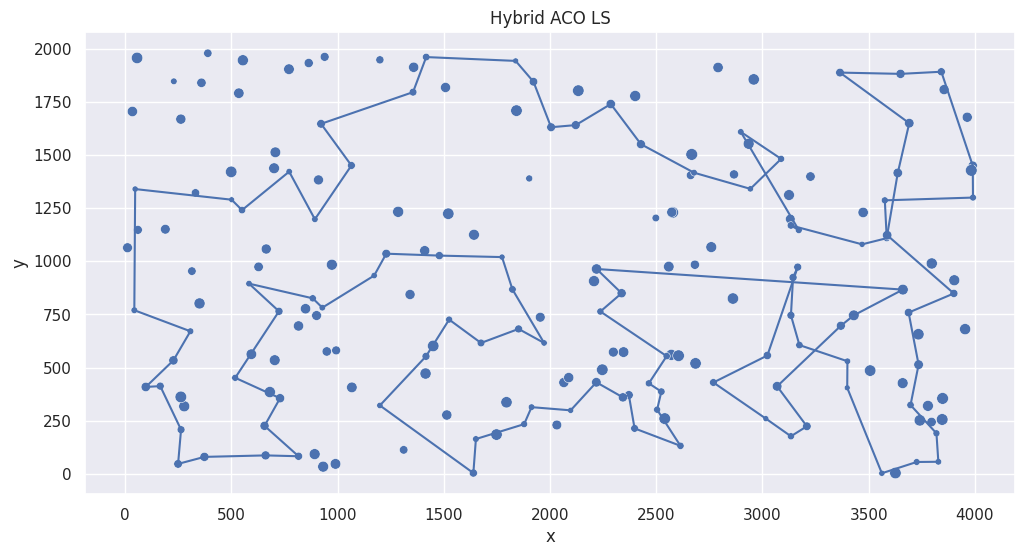

In [42]:
plot(dataset_A, overall_best_tour, 'Hybrid ACO LS')

In [34]:
solver_B = SelectiveACO_ILS(
    distances=distance_matrix_B,
    selection_percentage=0.5,
    n_ants=45,
    alpha=1.3,
    beta=2.8,
    rho=0.12,
    q0=0.82,
    max_time=450,
    ils_iterations=200
)

n_runs = 5

best_lengths = []
run_times = []
overall_best_tour = None
overall_best_length = float('inf')

for i in range(n_runs):
    print(f'Run {i+1}/{n_runs}')
    tour, length, run_time = solver_B.solve()

    best_lengths.append(length)
    run_times.append(run_time)

    if length < overall_best_length:
        overall_best_length = length
        overall_best_tour = tour.copy()

stats = {
    'best_tour': overall_best_tour,
    'best_length': overall_best_length,
    'min_length': min(best_lengths),
    'max_length': max(best_lengths),
    'mean_length': np.mean(best_lengths),
    'min_time': min(run_times),
    'max_time': max(run_times),
    'mean_time': np.mean(run_times),
    'std_length': np.std(best_lengths),
    'std_time': np.std(run_times)
}

stats

Run 1/5
Run 2/5
Run 3/5
Run 4/5
Run 5/5


{'best_tour': [191,
  90,
  147,
  6,
  188,
  169,
  13,
  15,
  70,
  3,
  145,
  195,
  168,
  139,
  11,
  138,
  33,
  104,
  8,
  82,
  21,
  91,
  61,
  36,
  141,
  77,
  81,
  153,
  187,
  163,
  89,
  127,
  103,
  113,
  176,
  194,
  166,
  86,
  185,
  95,
  130,
  99,
  22,
  179,
  172,
  52,
  94,
  47,
  148,
  20,
  60,
  23,
  28,
  140,
  183,
  152,
  170,
  34,
  18,
  62,
  124,
  106,
  143,
  159,
  119,
  35,
  109,
  0,
  29,
  160,
  144,
  56,
  49,
  182,
  25,
  177,
  5,
  175,
  78,
  142,
  45,
  190,
  80,
  136,
  31,
  117,
  54,
  193,
  73,
  164,
  198,
  1,
  156,
  42,
  27,
  38,
  16,
  135,
  63,
  122],
 'best_length': 48544.0,
 'min_length': 48544.0,
 'max_length': 49564.0,
 'mean_length': 49238.6,
 'min_time': 450.4579839706421,
 'max_time': 451.30089139938354,
 'mean_time': 450.832523393631,
 'std_length': 365.8172221205557,
 'std_time': 0.2995352529854808}

In [35]:
overall_best_length

48544.0

In [36]:
overall_best_tour

[191,
 90,
 147,
 6,
 188,
 169,
 13,
 15,
 70,
 3,
 145,
 195,
 168,
 139,
 11,
 138,
 33,
 104,
 8,
 82,
 21,
 91,
 61,
 36,
 141,
 77,
 81,
 153,
 187,
 163,
 89,
 127,
 103,
 113,
 176,
 194,
 166,
 86,
 185,
 95,
 130,
 99,
 22,
 179,
 172,
 52,
 94,
 47,
 148,
 20,
 60,
 23,
 28,
 140,
 183,
 152,
 170,
 34,
 18,
 62,
 124,
 106,
 143,
 159,
 119,
 35,
 109,
 0,
 29,
 160,
 144,
 56,
 49,
 182,
 25,
 177,
 5,
 175,
 78,
 142,
 45,
 190,
 80,
 136,
 31,
 117,
 54,
 193,
 73,
 164,
 198,
 1,
 156,
 42,
 27,
 38,
 16,
 135,
 63,
 122]

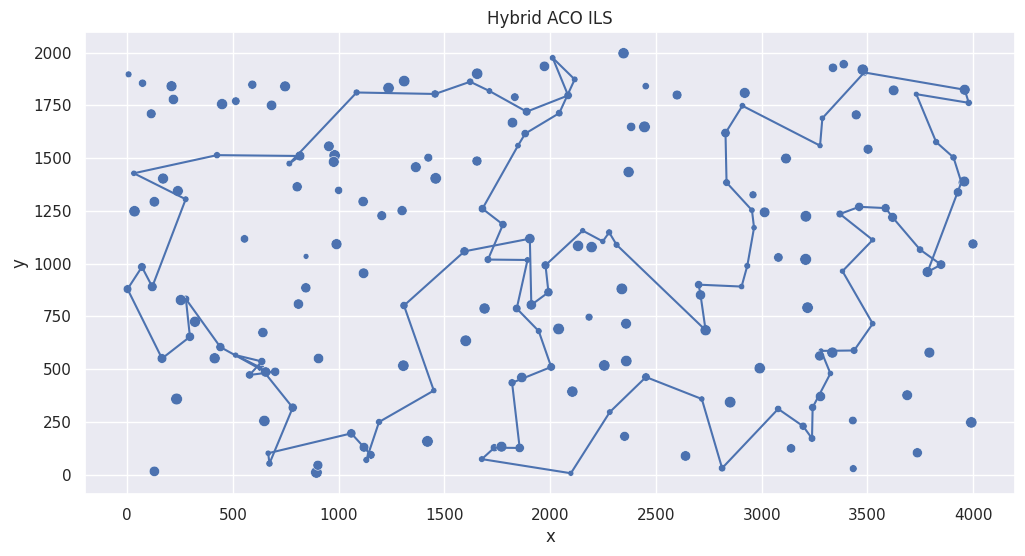

In [37]:
plot(dataset_B, overall_best_tour, 'Hybrid ACO LS')